In [1]:
import os
import copy
import time
import asyncio
import warnings
import logging

from pathlib import Path

import numpy as np
from astropy.io import fits

from scipy import ndimage
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter
from astropy.modeling import models, fitting


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 6]

#Import CWFS package
from lsst import cwfs
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile, aperture2image, showProjection
import lsst.cwfs.plots as plots

%matplotlib inline

In [2]:
import wget

In [3]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
logger = logging.getLogger('image_display_notebook')

In [4]:
def calc_CofM(array, offset=(0,0)):
    # Function takes a a 2d Array and computes the CofM
    
    # offset is the coordinate of the minimum y and x pixel
    
    
    #just make it easier to parse the code below
    shape=array.shape
        
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, shape[0], 1)+ offset[0]
    ones_array_2d=np.ones([shape[1], shape[0]])
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # Can't just use the transpose of the y_index_arr_2d
    # since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, shape[1], 1) + offset[1]
    ones_array_2d=np.ones([shape[0], shape[1]])
    # array will be left to right so need to transpose
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d

    # Calculate the centroid
    y_CofM = np.sum(y_index_arr_2d*array)/np.sum(array)
    x_CofM = np.sum(x_index_arr_2d*array)/np.sum(array)
    
    logger.info('y_CofM is {}'.format(y_CofM))
    logger.info('x_CofM is {}'.format(x_CofM))

    return(y_CofM, x_CofM)

In [5]:
# This is just used to test the CofM algorithm.

def make_circle(yxdims, radius, center=None):
    
    #Creates a circle where the internal pixels equal 1 and the rest are zero
    
    #dims is y,x dimensions
    
    # If center isn't declared then put it at the center of the box
    if center==None:
        center=(yxdims[0]/2, yxdims[1]/2)
    
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, yxdims[1] , 1) - center[1]
    ones_array_2d=np.ones((yxdims[0], yxdims[1]))
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d
    
    # Can't just transpose x-indice array since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, yxdims[0], 1) - center[0]
    ones_array_2d=np.ones((yxdims[1],yxdims[0]))
    # array will be left to right so need to transpose
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # creates an array with a given side, and a circle of radius x and position xy
    r_arr= np.sqrt(y_index_arr_2d**2 + x_index_arr_2d**2)
    
    arr=np.zeros((yxdims[0],yxdims[1]) ,dtype=float)
    
    arr[r_arr < radius] = 1
    return(arr)

In [ ]:
# Testing the CofM code
center=(1400,750)
stamp=make_circle((2500,1400), 100, center=center)

calc_CofM(stamp)

# Now try with subimage and reference to corner
side=300
guess_center = np.array((1550, 610))
stamp2= stamp[guess_center[0]-side:guess_center[0]+side, 
              guess_center[1]-side:guess_center[1]+side].copy()
calc_CofM(stamp2, offset=(guess_center-side))

if False:
    fig, ax = plt.subplots(figsize=(7,6))
    ax.imshow(stamp, interpolation='none')
    stamp.shape

    fig2, ax2 = plt.subplots(figsize=(7,6))
    ax2.imshow(stamp2, interpolation='none')
    stamp2.shape

In [6]:
# Declare where data is located and where output will be written, notably the stacked doughnuts
data_folder = Path("/home/saluser/data/20191212")
output_folder = Path("/home/saluser/data/output")

In [7]:
intra_image_name_1 = "1576295822-HD35441-0-1"
extra_image_name_1 = "1576295890-HD35441-0-1"

In [21]:
intra_image_name_2 = "1576296527-HD35441-0-1"
extra_image_name_2 = "1576296595-HD35441-0-1"

In [33]:
intra_image_name_3 = "1576298031-HD35441-0-1"
extra_image_name_3 = "1576298144-HD35441-0-1"

In [34]:
intra_image_name = intra_image_name_3
extra_image_name = extra_image_name_3

In [35]:
wget_url = 'http://at-keener.cp.lsst.org:8000/data/'+intra_image_name+'.fits'
print(wget_url)
intra_fname = wget.download(wget_url, out=str(data_folder.joinpath(intra_image_name+".fits")))
print('Grabbed/Wrote {} via wget'.format(intra_fname))

http://at-keener.cp.lsst.org:8000/data/1576298031-HD35441-0-1.fits
Grabbed/Wrote /home/saluser/data/20191212/1576298031-HD35441-0-1.fits via wget


In [36]:
wget_url = 'http://at-keener.cp.lsst.org:8000/data/'+extra_image_name+'.fits'
print(wget_url)
extra_fname = wget.download(wget_url, out=str(data_folder.joinpath(extra_image_name+".fits")))
print('Grabbed/Wrote {} via wget'.format(intra_fname))

http://at-keener.cp.lsst.org:8000/data/1576298144-HD35441-0-1.fits
Grabbed/Wrote /home/saluser/data/20191212/1576298031-HD35441-0-1.fits via wget


In [37]:
# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(data_folder / intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(data_folder / extra_fname))[0].data

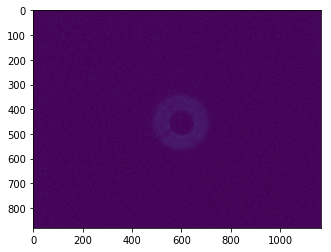

In [38]:
plt.imshow(intra_exp)

In [39]:
im_shape=intra_exp.shape
side=400
ceny=400 #round(im_shape[0]/2)
cenx=600 # round(im_shape[1]/2)
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

In [ ]:
# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=400
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[3,3])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(ceny, cenx)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    plt.imshow(im)
    im_filtered = medfilt(im,[3,3])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

321 447


/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

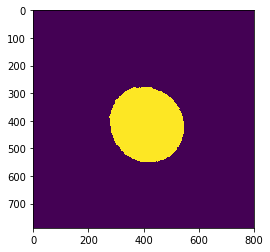

In [29]:
plt.imshow(im_filtered)

In [30]:
#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

In [31]:
# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.

# algo=Algorithm('exp',inst,1) # example
algo=Algorithm('exp',inst,1) # example

Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


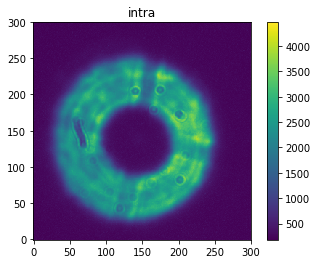

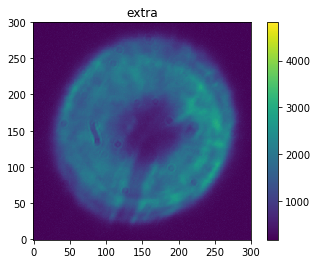

In [32]:
# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')

In [19]:
# Calculate zernikes and wavefront
# Note that this will change I1 and I2!
# if you ever want to rerun this with different parameters you have to reload I1 and I2!
start_t=time.time()
algo.runIt(inst,I1,I2,'onAxis')
# zer3 = np.array(algo.zer4UpNm,copy=True)
end_t=time.time()
print(f"took: {end_t-start_t}s")

took: 72.58850312232971s


In [20]:
zer_1 = np.array(algo.zer4UpNm[:9],copy=True)

In [ ]:
print(zer1)
print(zer2)
# print(zer3)

In [ ]:
# plot the zernikes
# plots.plotZer(algo.zer4UpNm[0:9],'nm')
# plots.plotZer(algo2.zer4UpNm[0:9],'nm')
plt.plot(zer1[0:9], 'o-')
plt.plot(zer2[0:9], 'o-')
# plt.plot(zer3[0:9], 'o-')
plt.grid()

In [ ]:
intra_image_name_3 = "1576286396-HD32313-0-1"
extra_image_name_3 = "1576286466-HD32313-0-1"

In [ ]:
intra_image_name_4 = "1576286665-HD32313-0-1"
extra_image_name_4 = "1576286733-HD32313-0-1"

In [ ]:
intra_image_name_5 = "1576287165-HD32313-0-1"
extra_image_name_5 = "1576287233-HD32313-0-1"

In [ ]:
intra_image_name_6 = "1576288278-HD32313-0-1"
extra_image_name_6 = "1576288345-HD32313-0-1"